In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Cargar el archivo de texto en un DataFrame
df = pd.read_csv('sell-in.txt.gz', sep='\t')


In [2]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [3]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn'],
      dtype='object')

In [4]:
productos = pd.read_csv('tb_productos.txt', sep='\t')

In [5]:
productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


Se hace una unión de los datasets

In [6]:
df_merged = pd.merge(df, productos, on='product_id', how='left')

In [7]:
stocks = pd.read_csv('tb_stocks.txt.gz', sep='\t')

In [8]:
stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [9]:
df_final = pd.merge(df_merged, stocks, on=['periodo', 'product_id'], how='left')

In [10]:

df_final['periodo'] = pd.to_datetime(df['periodo'])
df_final.set_index('periodo', inplace=True)


Comprobacion de la integridad de los datos

In [13]:
# Verificar valores faltantes
print(df_final.isnull().sum())

# Identificar valores atípicos
for columna in df_final.select_dtypes(include=['number']).columns:
    q1 = df_final[columna].quantile(0.25)
    q3 = df_final[columna].quantile(0.75)
    rango_intercuartil = q3 - q1
    valores_atipicos = df_final[(df_final[columna] < q1 - 1.5 * rango_intercuartil) | (df_final[columna] > q3 + 1.5 * rango_intercuartil)]
    print(f"Valores atípicos en {columna}: {valores_atipicos.shape[0]}")

customer_id                    0
product_id                     0
plan_precios_cuidados          0
cust_request_qty               0
cust_request_tn                0
tn                             0
cat1                        7448
cat2                        7448
cat3                        7448
brand                       7448
sku_size                    7448
stock_final              1839319
dtype: int64
Valores atípicos en customer_id: 6415
Valores atípicos en product_id: 0
Valores atípicos en plan_precios_cuidados: 34029
Valores atípicos en cust_request_qty: 318215
Valores atípicos en cust_request_tn: 444119
Valores atípicos en tn: 442925
Valores atípicos en sku_size: 173612
Valores atípicos en stock_final: 128207


Análisis exploratorio de variables

In [16]:

import seaborn as sns

# Estadísticas descriptivas para variables numéricas
print(df_final.describe())


        customer_id    product_id  plan_precios_cuidados  cust_request_qty  \
count     37.000000     37.000000                   37.0         37.000000   
mean   10212.324324  20475.243243                    0.0          2.351351   
std      168.724143    245.280271                    0.0          5.682411   
min    10002.000000  20009.000000                    0.0          1.000000   
25%    10073.000000  20230.000000                    0.0          1.000000   
50%    10159.000000  20496.000000                    0.0          1.000000   
75%    10351.000000  20710.000000                    0.0          1.000000   
max    10566.000000  20855.000000                    0.0         35.000000   

       cust_request_tn         tn     sku_size  stock_final  
count        37.000000  37.000000    37.000000    15.000000  
mean          0.088061   0.088061   400.243243    13.357542  
std           0.163728   0.163728   672.032961    14.494458  
min           0.001360   0.001360     5.000000   

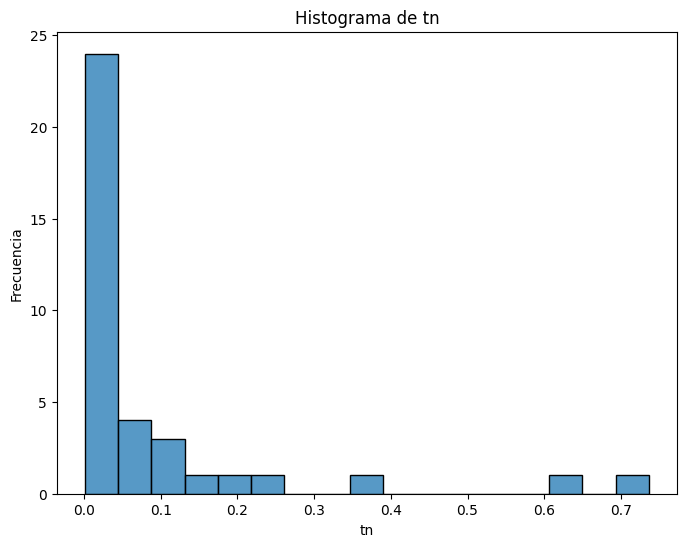

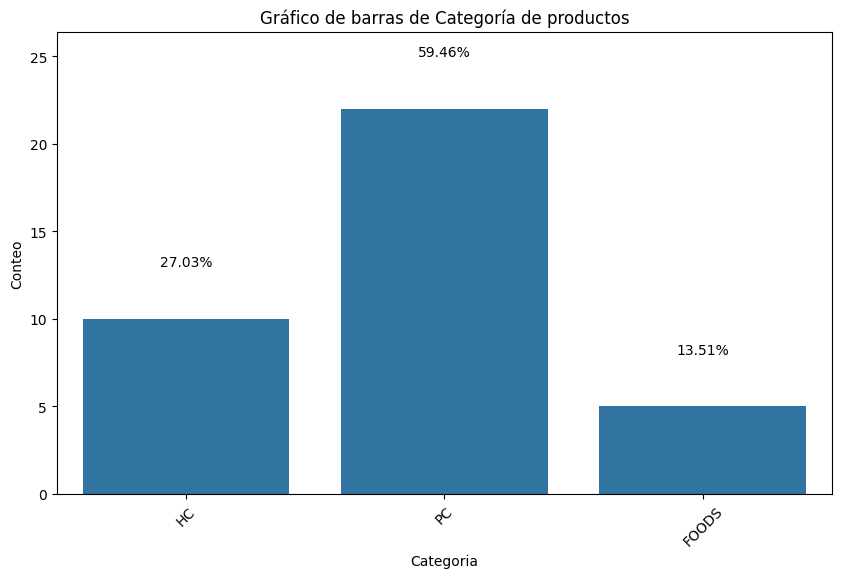

In [22]:
df_final = df_final[~df_final.index.duplicated(keep='first')]


# Histograma para una variable numérica
plt.figure(figsize=(8, 6))
sns.histplot(data=df_final, x='tn')
plt.title('Histograma de tn')  # Título del gráfico
plt.xlabel('tn')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cat1', data=df_final)
plt.title('Gráfico de barras de Categoría de productos')  # Título del gráfico
plt.xlabel('Categoria')  # Etiqueta del eje x
plt.ylabel('Conteo')  # Etiqueta del eje y
plt.xticks(rotation=45)

total = len(df_final)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

# Ajusta los límites del eje y
ax.set_ylim(0, 1.2*df_final['cat1'].value_counts().max())

plt.show()

Análisis de relaciones

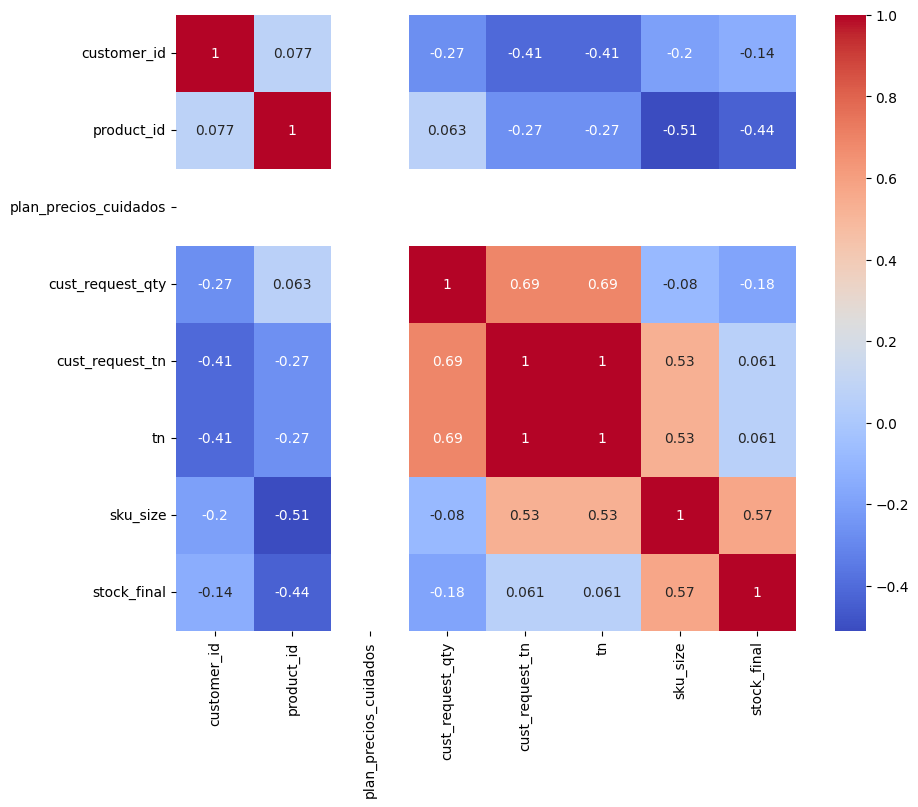

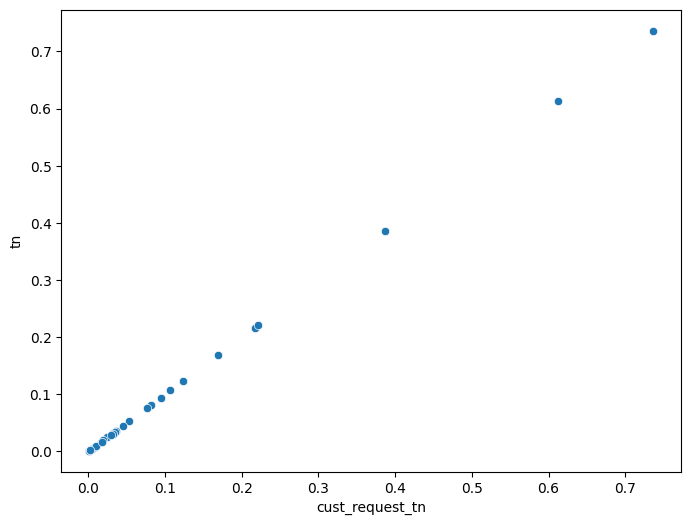

In [24]:
# Matriz de correlación
correlaciones = df_final.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final)
plt.show()


Análisis de tendencia y estacionalidad

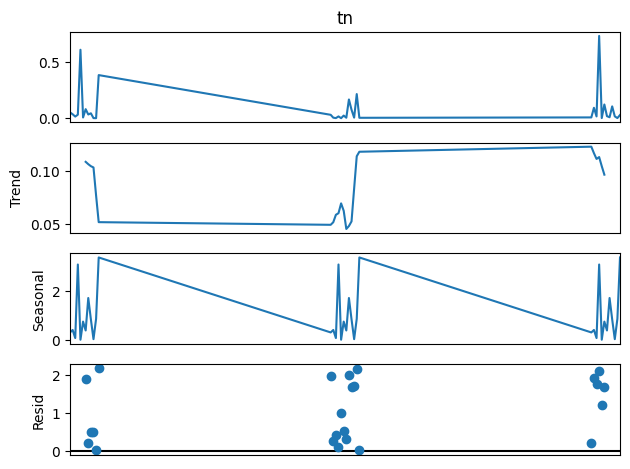

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Crear serie de tiempo de ventas totales
ventas_totales = df_final.groupby('periodo')['tn'].sum()

# Descomposición de la serie de tiempo
descomposicion = seasonal_decompose(ventas_totales, model='multiplicative', period=12)  # Periodo de 12 meses para estacionalidad anual

# Graficar componentes de la serie
descomposicion.plot()
plt.show()

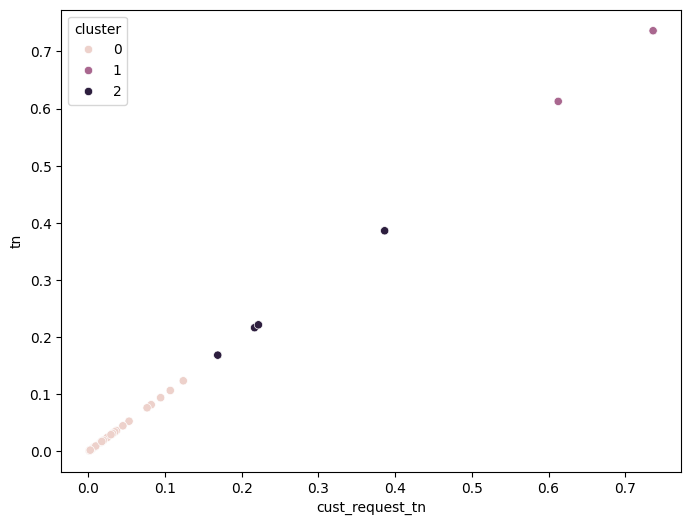

In [28]:
from sklearn.cluster import KMeans

# Seleccionar características relevantes
caracteristicas = df_final[['tn', 'cust_request_tn',]]

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(caracteristicas)

# Agregar etiquetas de cluster a los datos
df_final['cluster'] = kmeans.labels_

# Visualizar clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final, hue='cluster')
plt.show()